<b> Functions <b>

In [637]:
from qutip import *
import pylab as py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sympy import Heaviside, S


def heaviside(x):
    if x > 0 :
        return 1
    if x == 0:
        return 0
    if x < 0 :
        return 0

def modHeaviside(x):
    if x ==0:
        return Heaviside(0, S.Half)
    else:
        return Heaviside(x)
    
def nega(rho, subsys):
    
    #create mask which counts the number of possible subsystems
    x = [0 for i in rho.dims[0]]
   
    #assigns a 1 in the position of the subsystem for which we want to compute the negativity
    x[subsys] = 1
        
    #takes partial transpose with respect to subsys x
    rho_pt = partial_transpose(rho, x)
    
    #finds eivenvalues of pt matrix
    eig = rho_pt.eigenenergies()
    
    #finds abs value of the eigenvalues
    abs_eig = abs(eig)
    
    negat = 0 #initialize value of negativity
    
    #takes the difference 
    diff = (abs_eig - eig)
    
    
    #computes negativity
    for el in diff:
        negat += el

    
    return negat


<b> Parameters <b>

In [750]:
# wc= 1  # frequency of the cavity photons
# wa= 0.1  # transition frequency of the qubits


# N = 2      # number of cavity fock states (N-1 photons inn the cavity)
# n_th_a = 0.0           # temperature in frequency units
# g = 0.05*wc # coupling strength


# #time settings
# ti = 0 #initial time
# tf = 40 #final time
# steps = 1001 #number of steps
# tau_list = np.linspace(ti,tf,steps) # vector of time steps

wc = 10**(9)*2*np.pi*4.343 # frequency of the cavity photons
wa = 10**(9)*2*np.pi*5.439  # transition frequency of the qubits

N = 2      # number of cavity fock states (N-1 photons in the cavity)
n_th_a = 0.0           # temperature in frequency units
g = 10**(6)*2*np.pi*3000 # coupling strength
delta = 0.1

#LONG-TIME SETTINGS
ti = 0 #initial time
tf = 10**(-9)*100 #final time
steps = 6000 #number of steps
tau_list = np.linspace(ti,tf,steps) # vector of time steps
print((tf-ti)/steps)
# print((tau_list))

# # SHORT-TIME EVOLUTION TIME SETTINGS
# #time settings
# ti = 0 #initial time
# tf = 10**(-10)*1.5 #final time
# steps = 114 #number of steps
# tau_list = np.linspace(ti,tf,steps) # vector of time steps


1.6666666666666667e-11


# Dynamical coupling

9.192866335723479e-11


/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


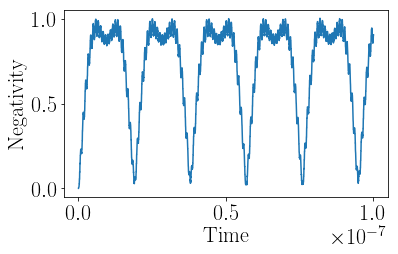

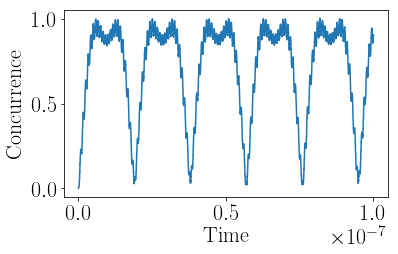

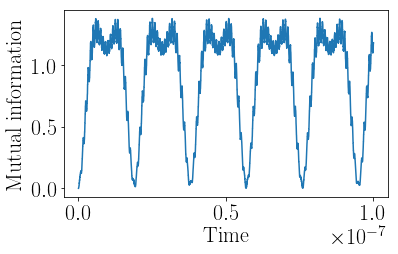

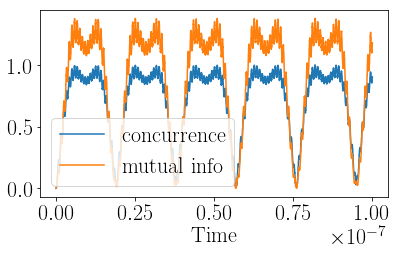

In [754]:
# #time settings
# ti = 0 #initial time
# tf = 10**(-10)*2 #final time
# steps = 1500 #number of steps
# tau_list = np.linspace(ti,tf,steps) # vector of time steps

# analytical and numerical correspond for T_num = pi/2wa, T_an = 2pi/wa
# T = np.pi/2*wa 

# T = 2*np.pi/(wa+wc)

T=2*np.pi/(2*wa)

print(T)
freq = 2*np.pi/T

# intial state (ground state)
psi0 = tensor(basis(N,0), basis(2,0), basis(2,0))    # start with 0 excited atom and 0 photons



# density matrix
rho0 = ket2dm(psi0) #turns ket into a density matrix




# operators
a  = tensor(destroy(N), qeye(2), qeye(2)) #destroy cavity photon
sm1 = tensor(qeye(N), destroy(2), qeye(2)) #destroy atom1 excitation
sm2 = tensor(qeye(N), qeye(2), destroy(2)) #destroy atom2 excitation


#list of collapse operator (dissipation ops) for separate baths (for Lindblad's equation)    
c_op_list = []


    

# Rabi model Hamiltonian for two atoms and a cavity mode for time dependent coupling

#high freq modulation
def H1_coeff(t,args):
    coeff = delta*g*heaviside(np.cos((freq)*t +3/2*np.pi))

#    print(coeff)
    return coeff

# def H1_coeff(t,args):
#     coeff = 0
#     for k in range(1000):
#         coeff += 1/2*g*(heaviside(t-k*T) -2*(heaviside(t-(2*k+1)*T/2)) + heaviside(t-(k+1)*T)  )
    
    
#     if(t>0):
#         coeff = coeff + g/2
    
# #     print(coeff)
#     return coeff

# # single switch
# def H1_coeff(t,args):
#     coeff = g*heaviside(t)
#     return coeff

H0 = wc*a.dag()*a + wa*sm1.dag()*sm1 + wa*sm2.dag()*sm2

H1 = (a.dag()*sm1 + a*sm1.dag() + a.dag()*sm2 + a*sm2.dag() + a*sm1 + a.dag()*sm1.dag() + a*sm2 + a.dag()*sm2.dag())


H = [H0,[H1,H1_coeff]]


cont = 0
    

#solve master equation
# output = mesolve(H, rho0, tau_list, c_op_list ,[a.dag() * a, sm1.dag() * sm1, sm2.dag() * sm2])  #stores expectation values of number of phontons, excitation of atom 1 and 2 

result = mesolve(H, rho0, tau_list, c_op_list)  #stores density matrix operator changing in time


# # plot excitation probabilities of photons and atoms
# plt.plot(tau_list, output.expect[0], label="Cavity")
# plt.plot(tau_list, output.expect[1], label="Atom 1 excited state")
# plt.plot(tau_list, output.expect[2], label="Atom 2 excited state")
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('Occupation probability')
# plt.title('Vacuum Rabi oscillations');
# plt.show()


#initialize entanglement measures vectors
neg_2 = np.zeros(steps) #negativity

mut_2 = np.zeros(steps) #mutual information

conc_2 = np.zeros(steps) #concurrence

x = [1,2] # selects the system to NOT trace over (0=photons, 1=atom1, 2=atom2)

for i in range(steps):
    states = result.states[i]*result.states[i].dag() # creates density matrix at each time 

    rhoqub = states.ptrace(x) # traces over the photonic degrees of freedom to obtain the density matrix of the qubits
    
    conc_2[i] = concurrence(rhoqub) # computes concurrence between qubits 
    
    mut_2[i] = entropy_mutual(rhoqub,0,1) #computes mutual information between the qubits
    
    neg_2[i] = nega(rhoqub, 0) #computes negativity between a qubit and the rest of the system
    

# np.save('data/conc_dyn_2q_num_an', conc_2)
# np.save('data/mut_dyn_2q_num_an', mut_2)
# np.save('data/neg_dyn_2q_num_an', neg_2)
    
    
#plot negativity
plt.plot(tau_list,neg_2)
plt.xlabel('Time')
plt.ylabel('Negativity')
plt.show()    
    
#plot concurrence
plt.plot(tau_list,conc_2)
plt.xlabel('Time')
plt.ylabel('Concurrence')
plt.show()


#plot mutual information
plt.plot(tau_list,mut_2)
plt.xlabel('Time')
plt.ylabel('Mutual information')
plt.show()

#plot conc/mut
plt.plot(tau_list,conc_2, label = 'concurrence')
plt.plot(tau_list,mut_2, label = 'mutual info')
plt.xlabel('Time')
plt.legend()
plt.show()




# Analytical solutions 

/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


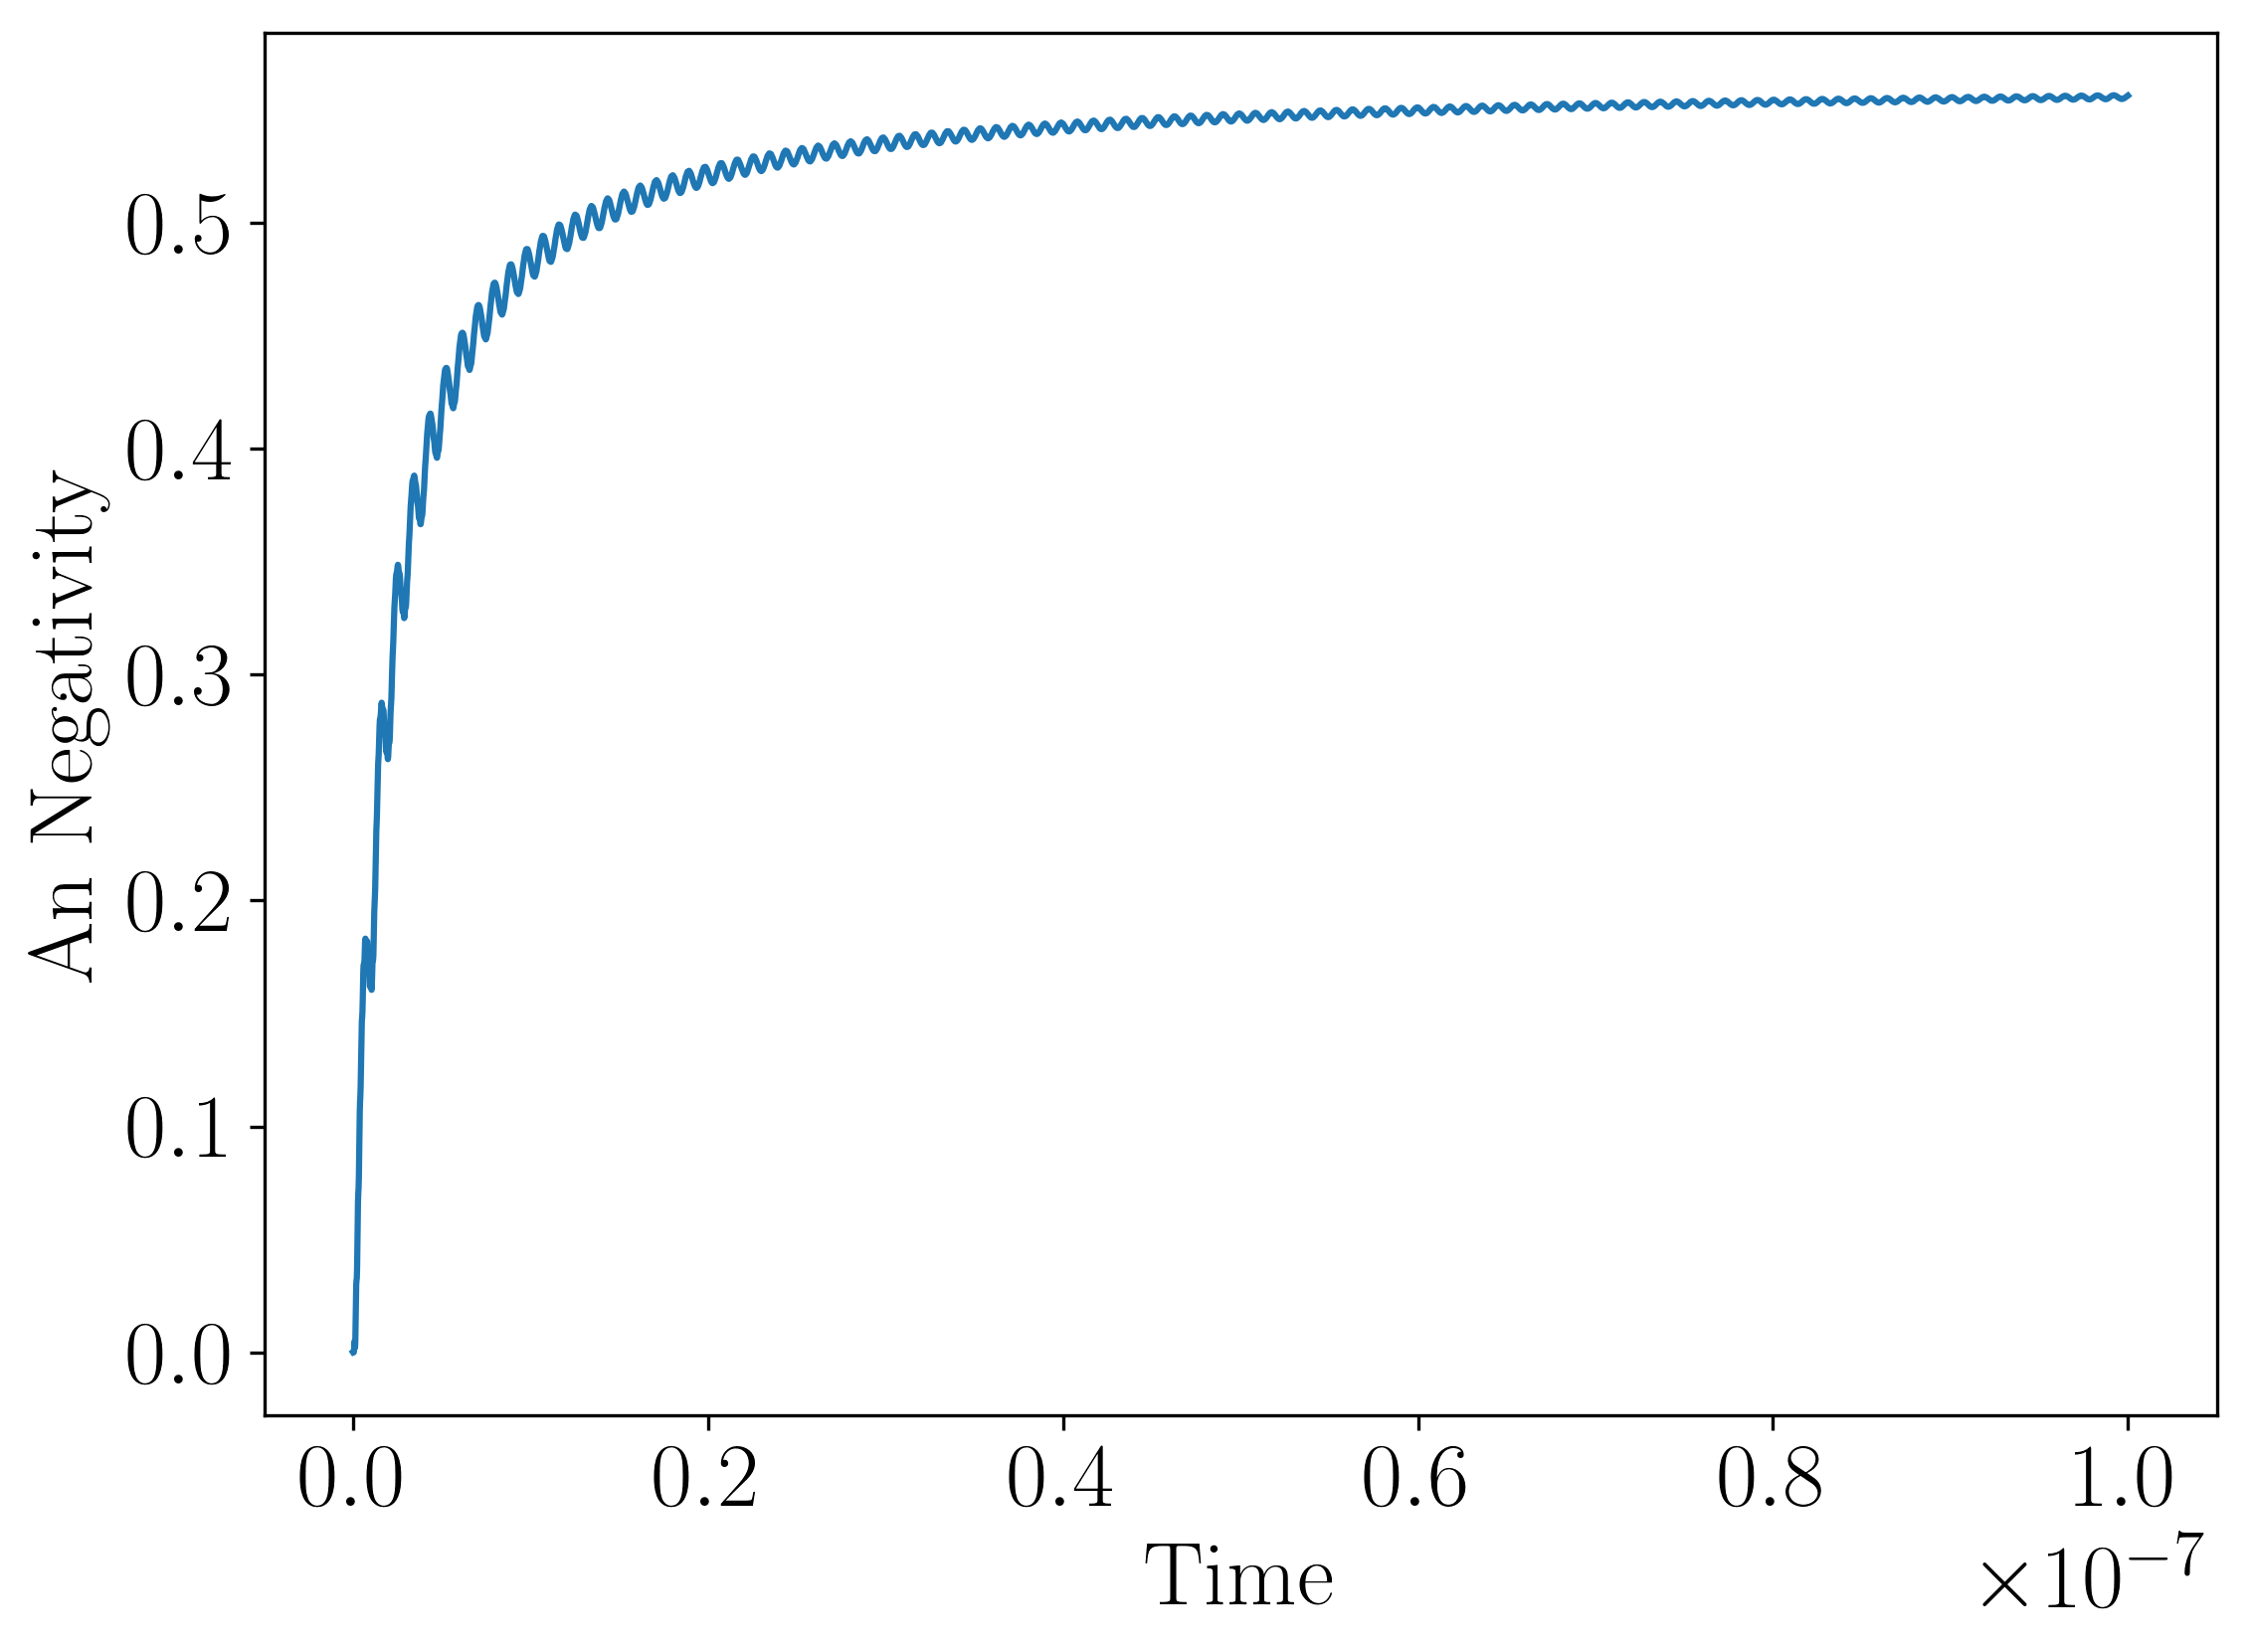

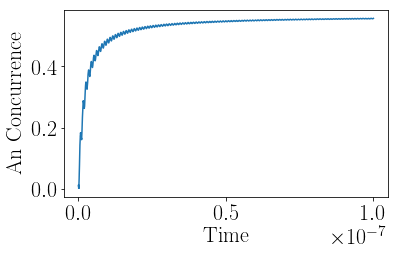

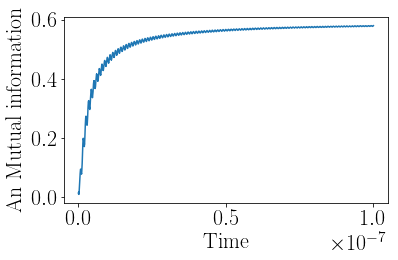

In [756]:


# T=2*np.pi/(wa+wc) # makes sol goes to 1

# T=6/(2*wa) # makes sol goes to 1

T=2*np.pi/(10*wa)

# analitycal results
cont = 0

conc_an = np.zeros(steps)

neg_an = np.zeros(steps) #negativity

mut_an = np.zeros(steps) #mutual information



for t in tau_list:
    


# # #general states

# #     T=0 # high frequency limit
    

#     a11 = -g/(2*(wc+wa))*(1 - (2*np.exp(-complex(0,1)*(wc+wa)*t))/(1+np.exp(complex(0,1)*(wc+wa)*T/2)) )
#     a12 = a11

    
#     a21 = (g**2*(2*np.exp(-complex(0,1)*t*(wa + wc)) + complex(0,1)*(2*t + T)*(wa + wc) - 2*(1/(np.cos((T/4*(wa + wc)))))**2 - (2*complex(0,1))*(1 + np.exp((-complex(0,1))*t*(wa + wc)))*np.tan((T*(wa + wc))/4)))/(4*(wa + wc)**2)

#     b0 = 1/(wa**2 + wa*wc)
#     b1 = 2*complex(0,1)*np.exp(-complex(0,1)*t*(wa+wc))*(complex(0,1) + np.tan(T/4*(wa+wc)))/(wa**2 - wc**2)
#     b2 = np.exp(-2*complex(0,1)*t*wa)*(wa+wc)/(wa*(wa-wc)*(wa+wc))
#     b3 = np.exp(-2*complex(0,1)*t*wa)*(-2*complex(0,1)*wc*np.tan(T*wa/2))/(wa*(wa-wc)*(wa+wc))
#     b4 = np.exp(-2*complex(0,1)*t*wa)*( 2*wa*np.tan(T*(wc-wa)/4)*(complex(0,1)+np.tan(T*(wa+wc)/4))  )/(wa*(wa-wc)*(wa+wc))
    
#     a22 = (g**2)/4*(b0+b1+b2+b3+b4)

#     #state found analytically
#     psi0_an = tensor(basis(N,0), basis(2,0), basis(2,0)) + (a11)*tensor(basis(N,1), basis(2,1), basis(2,0)) + (a12)*tensor(basis(N,1), basis(2,0), basis(2,1)) + a21*tensor(basis(N,0), basis(2,0), basis(2,0)) + a22*tensor(basis(N,0), basis(2,1), basis(2,1)) 
#     psi0_an = psi0_an.unit()

    
    
    
## T= 2pi/2wa case (only work at short times (few nanoseconds) before breaking down)

    a11 = -g/(2*(wc+wa))*(1 - (2*np.exp(-complex(0,1)*(wc+wa)*t))/(1+np.exp(complex(0,1)*(wc+wa)*np.pi/(2*wa))) )
    a12 = a11
    
    
    b00 = 2*wa + 4*np.exp(-complex(0,1)*t*(wa+wc))*wa
    b01 = 4*np.exp(complex(0,1)*(np.pi-2*t*wa)*(wa+wc)/(2*wa))*wa
    b02 = complex(0,1)*np.pi*(wa+wc) + 2*complex(0,1)*t*wa*(wa+wc)
    b03 = -complex(0,1)*np.exp(complex(0,1)*np.pi*wc/wa)*(wa*(2*complex(0,1)+np.pi+2*t*wa) +wc*(np.pi + 2*t*wa))
    b04 = -2*np.exp(complex(0,1)*wc/(2*wa))*(wa*(4*complex(0,1)+np.pi+2*t*wa) + wc*(np.pi+2*t*wa))
    
    
    a21 = g**2/(4*(1 + np.exp(( complex(0,1)*np.pi*(wa + wc))/(2*wa)))**2*wa*(wa + wc)**2)*(b00+b01+b02+b03+b04)
    
    b10 = 1/wa - (4*np.exp(-complex(0,1)*t*(wa + wc)))/((1 + np.exp((complex(0,1)*np.pi*(wa + wc))/(2*wa)) )*(wa - wc))
    b11 = (1 - complex(0,1)*np.exp((complex(0,1)*np.pi*wc)/(2*wa)))*(-4*complex(0,1) + np.pi)*wc**2
    b12 = 4*wa*wc*(2*complex(0,1) - np.pi + 2*t*wc + np.exp((complex(0,1)*np.pi*wc)/(2*wa))*(2 - 2*complex(0,1)*t*wc) )
    b13 = wa**2*(4*complex(0,1) + 3*np.pi - 8*t*wc + np.exp((complex(0,1)*np.pi*wc)/(2*wa))*(4 + complex(0,1)*np.pi + 8*complex(0,1)*t*wc))
   
    
    a22 = (1/(4*(wa + wc)))*(g**2)*(b10 + np.exp(-2*complex(0,1)*t*wa)*(1 + np.exp((complex(0,1)*np.pi*wc)/wa))*(b11+b12+b13)/((complex(0,1) + np.exp((complex(0,1)*np.pi*wc)/(2*wa)))**2*(1 + np.exp((complex(0,1)*np.pi*(wa + wc))/(2*wa)))*np.pi*wa*(wa - wc)**2) )

    psi0_an = tensor(basis(N,0), basis(2,0), basis(2,0)) + delta*(a11)*tensor(basis(N,1), basis(2,1), basis(2,0)) + delta*(a12)*tensor(basis(N,1), basis(2,0), basis(2,1)) + delta**2*a21*tensor(basis(N,0), basis(2,0), basis(2,0)) + delta**2*a22*tensor(basis(N,0), basis(2,1), basis(2,1)) 
    psi0_an = psi0_an.unit()    



    #density matrix
    rho0_an = ket2dm(psi0_an)

    x = [1,2] # selects the system to NOT trace over (0=photons, 1=atom1, 2=atom2)
    rhoqub_an = rho0_an.ptrace(x)

    conc_an[cont] = concurrence(rhoqub_an)

    mut_an[cont] = entropy_mutual(rhoqub_an,0,1) #computes mutual information between the qubits

    neg_an[cont] = nega(rhoqub_an, 0) #computes negativity between a qubit and the rest of the system

    cont += 1


#plot negativity
plt.plot(tau_list,neg_an)
plt.xlabel('Time')
plt.ylabel('An Negativity')
plt.show()    

#plot concurrence
plt.plot(tau_list,conc_an)
plt.xlabel('Time')
plt.ylabel('An Concurrence')
plt.show()


#plot mutual information
plt.plot(tau_list,mut_an)
plt.xlabel('Time')
plt.ylabel('An Mutual information')
plt.show()

#     #plot conc/mut
#     plt.plot(tau_list,conc_an, label = 'concurrence')
#     plt.plot(tau_list,mut_an, label = 'mutual info')
#     plt.xlabel('Time')
#     plt.legend()
#     plt.show()



# Compare analytical and numerical results

In [755]:
#changes plot parameters
plt.rcParams.update({'font.size': 22})
plt.rcParams.update({'figure.autolayout': True})
# matplotlib.rcParams['mathtext.rm'] = 'Arial'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')






#compare analytical and numerical results for the concurrence

# c_an = np.load("data/conc_ana_2q_num_an.npy")
# c = np.load("data/conc_avg_2q_num_an.npy")
# c_2 = np.load("data/conc_dyn_2q_num_an.npy")

plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
plt.plot(tau_list*10**9, conc_an, label = 'Perturbation')
plt.plot(tau_list*10**9, conc_2,dashes=[1, 1], label = 'Switching')
# plt.plot(tau_list*10**9, c_2*10**3, label = 'Switching')
plt.xlabel(r' Time (ns)', fontsize = 22)
plt.ylabel(r' Concurrence ', fontsize = 22)
# plt.ylabel(r' Concurrence')
plt.legend(loc=2)
ymin = -0.1*max(conc_2)
ymax = max(conc_2)+1.5*max(conc_2)
plt.ylim((ymin,ymax)) # sets limit for y-axis

locs, labels = plt.yticks()
labels = [str(round(e,2)) for e in locs if e >= 0]#locs
locs = [e for e in locs if e>=0]
plt.yticks(locs, labels)

plt.savefig('concurrence_2q_num_an.eps', dpi = 300)
plt.show()



#compare analytical and numerical results for the mutual

m_an = np.load("data/mut_ana_2q_num_an.npy")
m = np.load("data/mut_avg_2q_num_an.npy")
m_2 = np.load("data/mut_dyn_2q_num_an.npy")

plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
plt.plot(tau_list*10**9, mut_an, label = 'Perturbation')
plt.plot(tau_list*10**9, mut_2,dashes=[1, 1], label = 'Switching')
# plt.plot(tau_list*10**9, m_2*10**4, label = 'Switching')
plt.xlabel(r' Time (ns)', fontsize = 22 )
plt.ylabel(r' Mutual Information ', fontsize = 22)
# plt.ylabel(r' Mutual information')
plt.legend(loc=2)
ymin = -0.1*max(mut_2)
ymax = max(2*mut_2)+1.5*max(2*mut_2)
plt.ylim((ymin,ymax)) # sets limit for y-axis

locs, labels = plt.yticks()
labels = [str(round(e,2)) for e in locs if e >= 0]#locs
locs = [e for e in locs if e>=0]
plt.yticks(locs, labels)

plt.savefig('mutual_info_2q_num_an.eps', dpi = 300)
plt.show()




#compare analytical and numerical results for the negativity
# n_an = np.load("data/neg_ana_2q_num_an.npy")
# n = np.load("data/neg_avg_2q_num_an.npy")
# n_2 = np.load("data/neg_dyn_2q_num_an.npy")

plt.figure(num=None, figsize=(8, 6), dpi=300, facecolor='w', edgecolor='k')
plt.plot(tau_list*10**9, neg_an, label = 'Perturbation')
plt.plot(tau_list*10**9, neg_2,dashes=[1, 1], label = 'Switching')
# plt.plot(tau_list*10**9, n_2*10**3, label = 'Switching')
plt.xlabel(r' Time (ns)', fontsize = 22 )
plt.ylabel(r' Negativity ', fontsize = 22)
# plt.ylabel(r' Negativity')
plt.legend(loc=2)
ymin = -0.1*max(neg_2)
ymax = max(neg_2)+1.5*max(neg_2)
plt.ylim((ymin,ymax)) # sets limit for y-axis
 
locs, labels = plt.yticks()
labels = [str(round(e,2)) for e in locs if e >= 0]#locs
locs = [e for e in locs if e>=0]
plt.yticks(locs, labels)

plt.savefig('negativity_2q_num_an.eps', dpi = 300)
plt.show()







ValueError: x and y must have same first dimension, but have shapes (6000,) and (4000,)

In [642]:
from sympy import Heaviside
for t in range(-10,100):
    print(Heaviside(t))

0
0
0
0
0
0
0
0
0
0
Heaviside(0)
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [643]:
print('switching time',1/(20*wa))
print('time step',2*10**-9/5000)
print('cavity round-trip time',np.pi/(wc))

switching time 1.4630901185134708e-12
time step 4e-13
cavity round-trip time 1.1512779184895233e-10


9.192866335723479e-11
1e-12
[0. 1. 1. ... 0. 0. 0.]


/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


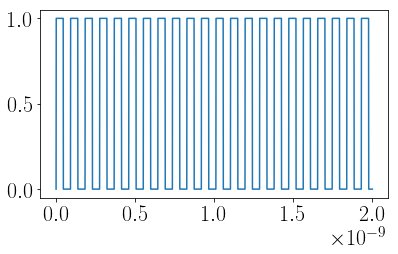

In [644]:
wc = 10**(9)*2*np.pi*4.343 # frequency of the cavity photons
wa = 10**(9)*2*np.pi*5.439  # transition frequency of the qubits
T = 2*np.pi/(2*wa) # half period of the square wave 
print(T)

#LONG-TIME SETTINGS
ti = 0 #initial time
tf = 10**(-9)*2 #final time
steps = 2000 #number of steps
tau_list = np.linspace(ti,tf,steps) # vector of time steps
print((tf-ti)/steps)

# T=5

# y = np.linspace(0,100,101)
# print(y)

f1 = np.zeros(len(tau_list))

for counter, el in enumerate(tau_list):
    f1[counter]= 0
    for k in range(1000):
        f1[counter] += 1/2*(heaviside(el-k*T) -2*(heaviside(el-(2*k+1)*T/2)) + heaviside(el-(k+1)*T)  )
    
    if(counter>0):
        f1[counter] = f1[counter] + 1/2
print(f1)

plt.plot(tau_list,f1)
plt.show()



[0. 1. 1. ... 0. 0. 0.]


/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


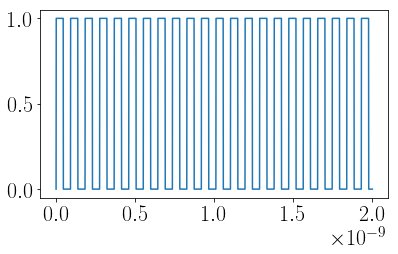

yes


In [645]:
freq = 2*np.pi/T

# freq = np.pi/T

# t = pi/freq

# y = np.linspace(0,100,101)
# print(y)

f2 = np.zeros(len(tau_list))

for counter, el in enumerate(tau_list):
    f2[counter]= heaviside(np.cos((freq)*el+3/2*np.pi))
    

print(f2)

plt.plot(tau_list,f2)
plt.show()

# freq =0.3
# T = 20
# x = T*freq

# print(x)

if f1.all() == f2.all():
    print("yes")